#Code Implementation: DenseNet
## *Pytorch-DenseNet Architecture:
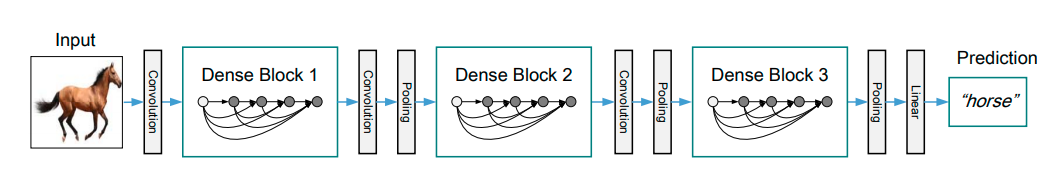

###The benefits of this structure are: Vanishing Gradient Improvements, Enhanced Feature Propagation, Feature Reuse, Saving the number of parameters.

###In the paper, three datasets were tested: ImageNet, CIFAR-10, and SVHN.
###In our implementation, we are going to conduct an experiment on CIFAR-10, and the learning-related settings are as follows:

    batch size: 64
    total epochs: 300, (but we consider 5 epochs)
    initial learning rate: 0.1
    learning rate decay: x0.1 at 150 epochs, 225 epochs
    weight decay: 10e-4
    Nesterov momentum: 0.9 without dampening
    weight initialization: He initialization
 


Note that, the DenseNet architecture applicable to CIFAR-10 is differ from the architecture table presented in the paper, and we present it in the figure below.
## **DenseNet architecture for CIFAR-10
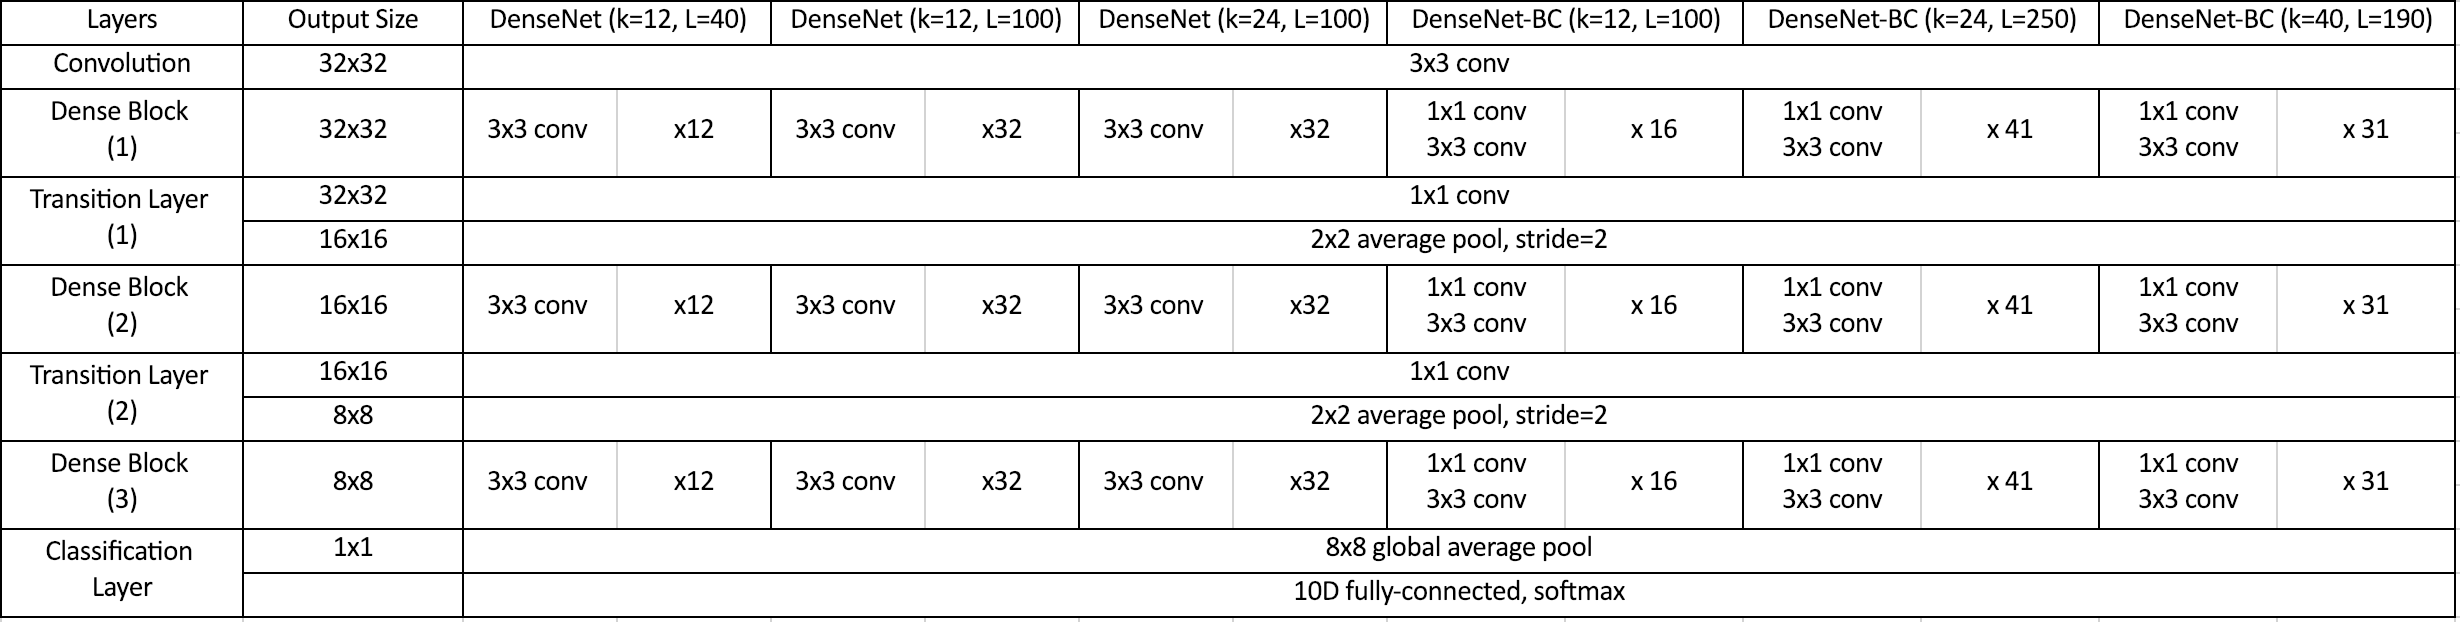

##Preparation Step

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
import glob
import PIL
from PIL import Image
from torch.utils import data as D
from torch.utils.data.sampler import SubsetRandomSampler
import random
import torchsummary

print(torch.__version__)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


In [ ]:
batch_size = 64
validation_ratio = 0.1
random_seed = 10
initial_lr = 0.1
#num_epoch = 300
num_epoch = 5

First, import various packages related to torch and libraries related to images, and set hyper-parameters related to training. For the batch size and initial learning rate, the values ​​presented in the paper were used, and for the validation set rate, 10% of the training data was used.

In [ ]:
transform_train = transforms.Compose([
        #transforms.Resize(32),
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])

transform_validation = transforms.Compose([
        #transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])


transform_test = transforms.Compose([
        #transforms.Resize(32),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

validset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_validation)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

num_train = len(trainset)
indices = list(range(num_train))
split = int(np.floor(validation_ratio * num_train))

np.random.seed(random_seed)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, sampler=train_sampler, num_workers=0
)

valid_loader = torch.utils.data.DataLoader(
    validset, batch_size=batch_size, sampler=valid_sampler, num_workers=0
)

test_loader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=0
)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


This part means the part that creates each data loader by splitting it into training, validation, and test sets, and uses random crop and random horizontal flip augmentation for training. Also included is a preprocessing that normalizes the input image with the mean and variance of the CIFAR-10 dataset. 

##Module Class
We are going to create a class representing each module that composes DenseNet and assemble it to compose the entire architecture. First of all, the most basic bn_relu_conv class is as follows.

In [ ]:
class bn_relu_conv(nn.Module):
    def __init__(self, nin, nout, kernel_size, stride, padding, bias=False):
        super(bn_relu_conv, self).__init__()
        self.batch_norm = nn.BatchNorm2d(nin)
        self.relu = nn.ReLU(True)
        self.conv = nn.Conv2d(nin, nout, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)

    def forward(self, x):
        out = self.batch_norm(x)
        out = self.relu(out)
        out = self.conv(out)

        return out


##DenseNet and other layers impelemtation:
Literally, Batch Normalization – ReLU – Convolution operations are performed sequentially, and this composite function is frequently used in DenseNet, so it is created as a separate class for convenience.

##a) Bottleneck Layer

In [ ]:
class bottleneck_layer(nn.Sequential):
  def __init__(self, nin, growth_rate, drop_rate=0.2):    
      super(bottleneck_layer, self).__init__()
      
      self.add_module('conv_1x1', bn_relu_conv(nin=nin, nout=growth_rate*4, kernel_size=1, stride=1, padding=0, bias=False))
      self.add_module('conv_3x3', bn_relu_conv(nin=growth_rate*4, nout=growth_rate, kernel_size=3, stride=1, padding=1, bias=False))
      
      self.drop_rate = drop_rate
      
  def forward(self, x):
      bottleneck_output = super(bottleneck_layer, self).forward(x)
      if self.drop_rate > 0:
          bottleneck_output = F.dropout(bottleneck_output, p=self.drop_rate, training=self.training)
          
      bottleneck_output = torch.cat((x, bottleneck_output), 1)
      
      return bottleneck_output


The bottleneck layer is used in DenseNet-BC, and 1x1 convolution and 3x3 convolution operations are performed sequentially as described in the previous post. In addition, it is possible to check the change in the size of the output feature map of each operation in the code, and drop out is also implemented.

The most notable part here is the torch.cat function. It is a core part of DenseNet, and it can be implemented with a simple line that the feature map is accumulated channel-wise after every bottleneck layer. The value of 1 put as an argument of the 2nd parameter of the Cat function means the concatenation dimension, and the 1st dimension means the channel.

##b) Transition Layer

In [ ]:
class Transition_layer(nn.Sequential):
  def __init__(self, nin, theta=0.5):    
      super(Transition_layer, self).__init__()
      
      self.add_module('conv_1x1', bn_relu_conv(nin=nin, nout=int(nin*theta), kernel_size=1, stride=1, padding=0, bias=False))
      self.add_module('avg_pool_2x2', nn.AvgPool2d(kernel_size=2, stride=2, padding=0))


The transition layer, can be implemented simply. After 1x1 convolution, 2x2 average pooling is used, and the number of output feature maps of 1x1 convolution can be adjusted according to theta, which is the compression hyper parameter.

##c) DenseBlock
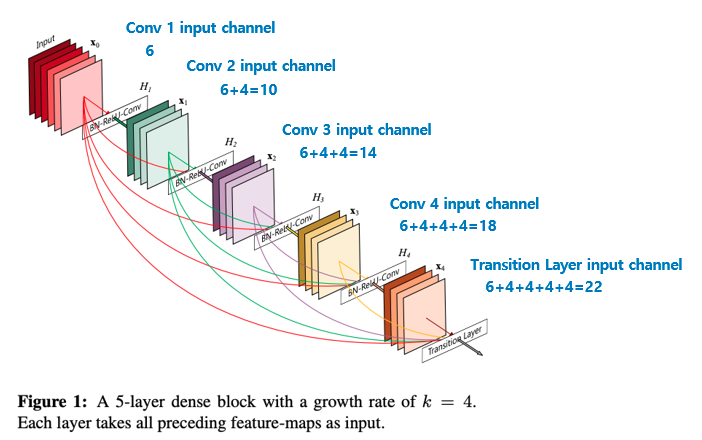

In [ ]:
class DenseBlock(nn.Sequential):
  def __init__(self, nin, num_bottleneck_layers, growth_rate, drop_rate=0.2):
      super(DenseBlock, self).__init__()
                        
      for i in range(num_bottleneck_layers):
          nin_bottleneck_layer = nin + growth_rate * i
          self.add_module('bottleneck_layer_%d' % i, bottleneck_layer(nin=nin_bottleneck_layer, growth_rate=growth_rate, drop_rate=drop_rate))


Lastly, DenseBlock can be implemented by connecting the bottleneck layers created above in turn according to the length of each DenseBlock layer, and can be implemented simply through a for statement. The input feature map (nin) of each bottleneck layer can be calculated by adding the growth rate to the number of first feature maps, which is defined as a variable called nin_bottleneck_layer.

##DenseNet-BC configuration
The next part to explain is the part that configures DenseNet-BC based on the module created above.

In [ ]:
class DenseNet(nn.Module):
    def __init__(self, growth_rate=12, num_layers=100, theta=0.5, drop_rate=0.2, num_classes=10):
        super(DenseNet, self).__init__()
        
        assert (num_layers - 4) % 6 == 0
        
        # (num_layers-4)//6 
        num_bottleneck_layers = (num_layers - 4) // 6
        
        # 32 x 32 x 3 --> 32 x 32 x (growth_rate*2)
        self.dense_init = nn.Conv2d(3, growth_rate*2, kernel_size=3, stride=1, padding=1, bias=True)
                
        # 32 x 32 x (growth_rate*2) --> 32 x 32 x [(growth_rate*2) + (growth_rate * num_bottleneck_layers)]
        self.dense_block_1 = DenseBlock(nin=growth_rate*2, num_bottleneck_layers=num_bottleneck_layers, growth_rate=growth_rate, drop_rate=drop_rate)

        # 32 x 32 x [(growth_rate*2) + (growth_rate * num_bottleneck_layers)] --> 16 x 16 x [(growth_rate*2) + (growth_rate * num_bottleneck_layers)]*theta
        nin_transition_layer_1 = (growth_rate*2) + (growth_rate * num_bottleneck_layers) 
        self.transition_layer_1 = Transition_layer(nin=nin_transition_layer_1, theta=theta)
        
        # 16 x 16 x nin_transition_layer_1*theta --> 16 x 16 x [nin_transition_layer_1*theta + (growth_rate * num_bottleneck_layers)]
        self.dense_block_2 = DenseBlock(nin=int(nin_transition_layer_1*theta), num_bottleneck_layers=num_bottleneck_layers, growth_rate=growth_rate, drop_rate=drop_rate)

        # 16 x 16 x [nin_transition_layer_1*theta + (growth_rate * num_bottleneck_layers)] --> 8 x 8 x [nin_transition_layer_1*theta + (growth_rate * num_bottleneck_layers)]*theta
        nin_transition_layer_2 = int(nin_transition_layer_1*theta) + (growth_rate * num_bottleneck_layers) 
        self.transition_layer_2 = Transition_layer(nin=nin_transition_layer_2, theta=theta)
        
        # 8 x 8 x nin_transition_layer_2*theta --> 8 x 8 x [nin_transition_layer_2*theta + (growth_rate * num_bottleneck_layers)]
        self.dense_block_3 = DenseBlock(nin=int(nin_transition_layer_2*theta), num_bottleneck_layers=num_bottleneck_layers, growth_rate=growth_rate, drop_rate=drop_rate)
        
        nin_fc_layer = int(nin_transition_layer_2*theta) + (growth_rate * num_bottleneck_layers) 
        
        # [nin_transition_layer_2*theta + (growth_rate * num_bottleneck_layers)] --> num_classes
        self.fc_layer = nn.Linear(nin_fc_layer, num_classes)
        
    def forward(self, x):
        dense_init_output = self.dense_init(x)
        
        dense_block_1_output = self.dense_block_1(dense_init_output)
        transition_layer_1_output = self.transition_layer_1(dense_block_1_output)
        
        dense_block_2_output = self.dense_block_2(transition_layer_1_output)
        transition_layer_2_output = self.transition_layer_2(dense_block_2_output)
        
        dense_block_3_output = self.dense_block_3(transition_layer_2_output)
        
        global_avg_pool_output = F.adaptive_avg_pool2d(dense_block_3_output, (1, 1))                
        global_avg_pool_output_flat = global_avg_pool_output.view(global_avg_pool_output.size(0), -1)

        output = self.fc_layer(global_avg_pool_output_flat)
        
        return output


After the first convolution, the Dense Block and Transition Layers are passed sequentially, and the part that connects to the fully-connected layer after going through global average pooling at the end is shown in the code above. How the shape of the feature map changes for each module is described in the comments above the declaration part of each module. Through this process of calculating the shape change for each layer, the understanding of architecture can be improved.

In [ ]:
def DenseNetBC_100_12():
    return DenseNet(growth_rate=12, num_layers=100, theta=0.5, drop_rate=0.2, num_classes=10)

def DenseNetBC_250_24():
    return DenseNet(growth_rate=24, num_layers=250, theta=0.5, drop_rate=0.2, num_classes=10)

def DenseNetBC_190_40():
    return DenseNet(growth_rate=40, num_layers=190, theta=0.5, drop_rate=0.2, num_classes=10)


The next part is the function that creates the three DenseNet-BC models presented in the paper through the DenseNet class created above. We can adjust the growth rate, num_layer, and also the compression level of the transition layer, drop out rate, etc.

In [ ]:
net = DenseNetBC_100_12()
net.to(device)


Now, if you put the architecture you created in the first torch.device you created, you can train on the GPU.

##Architecture Summary
The process of calculating the shape of the tensor after each operation of the architecture created earlier is helpful. To compare the shape calculated by you with the shape calculated in the actual architecture, you have to attach a print function to every layer. 

If only the shape of the previously created net and input image is input as an argument, the number of parameters and output shape of all operations are automatically calculated. In addition, you can easily check useful information, such as calculating the total number of parameters and the memory size required for learning.

In [ ]:
torchsummary.summary(net, (3, 32, 32))


Just add this one line and you can see how the output shape changes for each operation. In particular, in the case of DenseNet, it is necessary to check whether densely connectivity is well implemented while implementing the code. Using torch summary, debugging is easy.

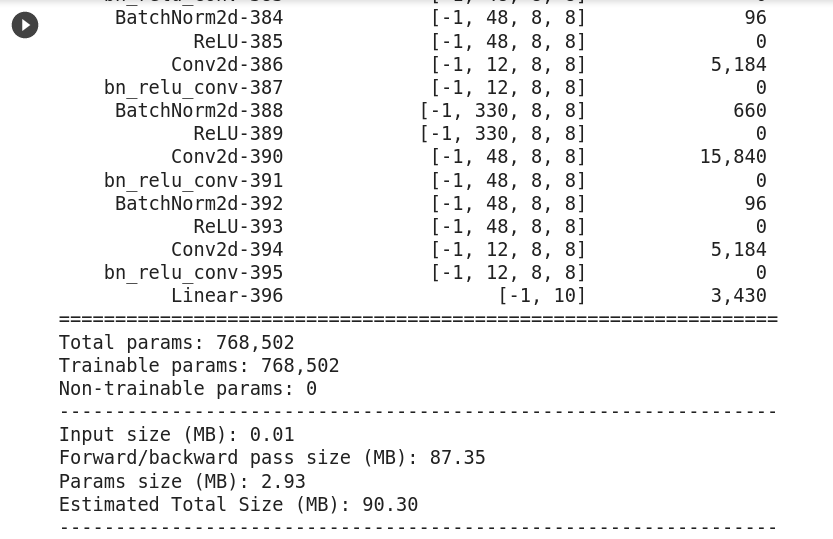

The figure above performs the model summary of DenseNet through touch summary, and summarizes the feature map shape of the first DenseBlock among them. You can see at a glance how the channel changes from the input feature map through the bn_relu_conv block, and you can see the process of increasing the number of feature maps by being converted to 48 channels in the bottleneck layer and then concating with the previous feature map.

#Training

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=initial_lr, momentum=0.9)
lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[int(num_epoch * 0.5), int(num_epoch * 0.75)], gamma=0.1, last_epoch=-1)

for epoch in range(num_epoch):  
    lr_scheduler.step()
    
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        show_period = 100
        if i % show_period == show_period-1:    # print every "show_period" mini-batches
            print('[%d, %5d/50000] loss: %.7f' %
                  (epoch + 1, (i + 1)*batch_size, running_loss / show_period))
            running_loss = 0.0
        
        
    # validation part
    correct = 0
    total = 0
    for i, data in enumerate(valid_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print('[%d epoch] Accuracy of the network on the validation images: %d %%' % 
          (epoch + 1, 100 * correct / total)
         )

print('Finished Training')


The next part to be explained is the part to learn, and it can be implemented simply as well. For the SGD optimizer, momentum is 0.9 and the learning rate is implemented using pytorch's learning rate scheduling. It is implemented using lr_scheduler.MultiStepLR because it is a method that multiplies by 0.1 times each at 50% and 75% of the total epoch .

And at the end of every 1 epoch, the accuracy is measured with the validation set, and in this example, model selection and learning curve plotting are not implemented. If necessary, you can add it and use it.

#Test

Test can be implemented easily by replacing val_loader with test_loader just like measuring accuracy with validation set.

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
                
        for i in range(labels.shape[0]):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))            
            
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i])) 


After testing the test set, the accuracy of each of the 10 classes is obtained, and the process of obtaining the overall accuracy is implemented in the code above.

--------------------------------
Conclusion:
--------------------------------------
In this practice work, we implemented and learned DenseNet-BC with PyTorch through google colab. First, we implemented each module and assembled it. We explained the process of summarizing the implemented architecture, and by understanding the entire process of implementing DenseNet, it is easy to implement other architectures based on this code.

#Other comments